In [2]:
import pandas as pd # to read/manipulate/write data from files
import numpy as np # to manipulate data/generate random numbers
import plotly.express as px # interactive visualizations
import seaborn as sns # static visualizations
import matplotlib.pyplot as plt # fine tune control over visualizations

from pathlib import Path # represent and interact with directories/folders in the operating system
from collections import namedtuple # structure data in an easy to consume way

import requests # retrieve data from an online source

In [3]:
# save directory we downloaded the ABCD data to `data_path`
data_path = Path("/home/jovyan/ABCD3")
# glob (match) all text files in the `data_path` directory
files = sorted(data_path.glob("*.txt"))

In [4]:
# We store the info in 4 different Python datatypes
data_elements = []
data_structures = {}
event_names = set()
StructureInfo = namedtuple("StructureInfo", field_names=["description", "eventnames"])

for text_file in files:
    # Extract data structure from filename
    data_structure = Path(text_file).name.split('.txt')[0]
    # Read the data structure and capture all the elements from the file
    # Note this could have been done using the data returned from the NDA API
    # We are using pandas to read both the first and second rows of the file as the header
    # Note: by convention dataframe variables contain `df` in the name.
    data_structure_df = pd.read_table(text_file, header=[0, 1], nrows=0)
    for data_element, metadata in data_structure_df.columns.values.tolist():
        data_elements.append([data_element, metadata, data_structure])

    
    # (Optional) Retrieve the eventnames in each structure. Some structures were only collected
    # at baseline while others were collected at specific or multiple timepoints
    events_in_structure = None
    if any(['eventname' == data_element for data_element in data_structure_df.columns.levels[0]]):
        # Here we are skipping the 2nd row of the file containing description using skiprows
        possible_event_names_df = pd.read_table(text_file, skiprows=[1], usecols=['eventname'])
        events_in_structure = possible_event_names_df.eventname.unique().tolist()
        event_names.update(events_in_structure)

    # (Optional) Retrieve the title for the structure using the NDA API
    rinfo = requests.get(f"https://nda.nih.gov/api/datadictionary/datastructure/{data_structure}").json()
    data_structures[data_structure] = StructureInfo(description=rinfo["title"] if "title" in rinfo else None,
                                                    eventnames=events_in_structure)

# Convert to a Pandas dataframe
data_elements_df = pd.DataFrame(data_elements, columns=["element", "description", "structure"])

In [10]:
data_elements_df.head()

,element,description,structure
0,collection_id,collection_id,abcd_abcls01
1,abcd_abcls01_id,abcd_abcls01_id,abcd_abcls01
2,dataset_id,dataset_id,abcd_abcls01
3,subjectkey,The NDAR Global Unique Identifier (GUID) for r...,abcd_abcls01
4,src_subject_id,Subject ID how it's defined in lab/project,abcd_abcls01


In [11]:
data_elements_df.to_csv("data_elements.tsv", sep="\t", index=None)

In [12]:
data_elements_df.shape

(75221, 3)

In [13]:
len(data_structures)

295

In [14]:
event_names

{'18_month_follow_up_arm_1',
 '1_year_follow_up_y_arm_1',
 '2_year_follow_up_y_arm_1',
 '30_month_follow_up_arm_1',
 '6_month_follow_up_arm_1',
 'baseline_year_1_arm_1',
 'screener_arm_1'}

In [15]:
data_elements_df.element.unique().shape

(72013,)

In [16]:
data_elements_df.query("element == 'smri_vol_scs_amygdalalh'")

,element,description,structure
30612,smri_vol_scs_amygdalalh,Volume in mm^3 of ASEG ROI left-amygdala,abcd_smrip201


In [17]:
structure = 'abcd_mri01'  # 'abcd_psb01'
example_structure_df = pd.read_table(data_path / f"{structure}.txt", header=[0, 1], nrows=0)
example_structure_df.columns.tolist()

[('collection_id', 'collection_id'),
 ('abcd_mri01_id', 'abcd_mri01_id'),
 ('dataset_id', 'dataset_id'),
 ('subjectkey',
  'The NDAR Global Unique Identifier (GUID) for research subject'),
 ('src_subject_id', "Subject ID how it's defined in lab/project"),
 ('interview_date',
  'Date on which the interview/genetic test/sampling/imaging/biospecimen was completed. MM/DD/YYYY'),
 ('interview_age',
  'Age in months at the time of the interview/test/sampling/imaging.'),
 ('sex', 'Sex of the subject'),
 ('eventname', 'The event name for which the data was collected'),
 ('mri_info_visitid', 'Visit name'),
 ('mri_info_manufacturer', 'Imaging device manufacturer'),
 ('mri_info_manufacturersmn', "Imaging device manufacturer's model name"),
 ('mri_info_deviceserialnumber',
  'Hashed version of imaging device serial number'),
 ('mri_info_magneticfieldstrength',
  'Magnetic field strength of imaging device in teslas'),
 ('mri_info_softwareversion', 'Imaging device software version'),
 ('mri_info_stu

In [13]:
NOEVENTS = {}
for data_structure, info in data_structures.items():
    if info.eventnames:
        if 'baseline_year_1_arm_1' in info.eventnames:
            print(f"{data_structure}: {info.description}")
    else:
        NOEVENTS[data_structure] = info

abcd_ant01: ABCD Youth Anthropometrics Modified From PhenX (ANT)
abcd_asrs01: ABCD Parent Adult Self Report Scores Aseba (ASR)
abcd_auto_postqc01: Automated Post-Processing QC Metrics
abcd_betnet02: ABCD rsfMRI Gordon Network Correlations
abcd_bisbas01: ABCD Youth Behavioral Inhibition/Behavioral Approach System Scales Modified from PhenX (BIS/BAS)
abcd_bpmt01: ABCD Brief Problem Monitor-Teacher Form For Ages 6-18 (BPMT)
abcd_cbcl01: ABCD Parent Child Behavior Checklist Raw Scores Aseba (CBCL)
abcd_cbcls01: ABCD Parent Child Behavior Checklist Scores Aseba (CBCL)
abcd_crpf01: ABCD Parent Community Risk and Protective Factors (CRPF)
abcd_ddtidp101: ABCD dMRI DTI Destrieux Parcellations Part 1
abcd_ddtidp201: ABCD dMRI DTI Destrieux Parcellations Part 2
abcd_ddtifp101: ABCD dMRI DTI Full Destrieux Parcellation Part 1
abcd_ddtifp201: ABCD dMRI DTI Full Destrieux Parcellation Part 2
abcd_devhxss01: ABCD Summary Scores Developmental History
abcd_dmdtifp101: ABCD dMRI DTI Full Part 1
abcd_dm

In [14]:
for data_structure, info in NOEVENTS.items():
    print(f"{data_structure}: {info.description}")

aurora01: Mobile Data
dhx01: ABCD Developmental History Questionnaire
fhxp201: ABCD Family History Assessment Part 2
fmriresults01: Processed MRI Data
guid_pseudoguid: None
omics_experiments: None
package_info: None
pps01: ABCD Prodromal Psychosis Scale
sph01: ABCD Pubertal Hormone Saliva
srpf01: ABCD School Risk and Protective Factors Survey


In [18]:
NOEVENTS = {}
for data_structure, info in data_structures.items():
    if info.eventnames:
        if '2_year_follow_up_y_arm_1' in info.eventnames:
            print(f"{data_structure}: {info.description}")
    else:
        NOEVENTS[data_structure] = info

abcd_abcls01: ABCD ABCL Scores
abcd_adbc01: ABCD Adult Behavior Checklist
abcd_ant01: ABCD Youth Anthropometrics Modified From PhenX (ANT)
abcd_asrs01: ABCD Parent Adult Self Report Scores Aseba (ASR)
abcd_auto_postqc01: Automated Post-Processing QC Metrics
abcd_betnet02: ABCD rsfMRI Gordon Network Correlations
abcd_bisbas01: ABCD Youth Behavioral Inhibition/Behavioral Approach System Scales Modified from PhenX (BIS/BAS)
abcd_bkfs01: ABCD Youth Block Food Screen
abcd_bp01: ABCD Youth Blood Pressure
abcd_bpm01: ABCD Youth Brief Problem Monitor
abcd_bpmt01: ABCD Brief Problem Monitor-Teacher Form For Ages 6-18 (BPMT)
abcd_cb01: ABCD Cyber Bully
abcd_cbcl01: ABCD Parent Child Behavior Checklist Raw Scores Aseba (CBCL)
abcd_cbcls01: ABCD Parent Child Behavior Checklist Scores Aseba (CBCL)
abcd_crpf01: ABCD Parent Community Risk and Protective Factors (CRPF)
abcd_ddtidp101: ABCD dMRI DTI Destrieux Parcellations Part 1
abcd_ddtidp201: ABCD dMRI DTI Destrieux Parcellations Part 2
abcd_ddtifp1

In [67]:
#abcd_pnhps01: ABCD Youth Peer Network Health Protective Scaler
#abcd_siss01: ABCD Social Influence Summary Scores

#abcd_eatqp01: ABCD Early Adolescent Temperament Questionnaire Parent

#midaparc03: ABCD Task fMRI MID Average Beta Weights Part 1
#midaparcp203: ABCD Task fMRI MID Average Beta Weights Part 2
#midr2bwp102: ABCD Task fMRI MID Run 2 Beta Weights Part 1
#midr2bwp202: ABCD Task fMRI MID Run 2 Beta Weights Part 2

#abcd_tr2bwdp01: ABCD Task fMRI MID Run 2 Beta Weights Destrieux Parcellations Part 1
#abcd_tr2bwdp202: ABCD Task fMRI MID Run 2 Beta Weights Destrieux Parcellations Part 2
#abcd_mhp02

#pnh_substance: lats 6 months friend suggested you use drugs (catagorical)
#pnh_encourage: last 6 months friend encouraged you to get involved with positive activityies (catagorical)

# anticipation of reward vs. neutral "tfmri_ma_acdn_b_scs_aalh", "tfmri_ma_acdn_b_scs_aarh"

# anticipation of loss vs. neutral"tfmri_ma_acvn_b_scs_aalh", "tfmri_ma_acvn_b_scs_aarh"

#"ehi_y_ss_scoreb", "race_ethnicity"

common = ["subjectkey", "interview_date", "interview_age", "eventname", "sex"]
demographic = ["site_id_l"] #"anthroheightcalc", "anthroweightcalc", 'neighborhood_crime_y', "demo_comb_income_v2_l", 'snellen_aid_y'
clinical = []
behavioral = ['pnh_substance', 'pnh_encourage', 'sit_scr_expr_mratdiff1', 'sit_scr_expr_mratdiff2', 'sit_scr_expr_mratdiff3', 'sit_scr_expr_mratdiff4']
cognitive = ['eatq_p_ss_effort_cont_ss', "eatq_p_ss_neg_affect_ss", 'eatq_p_ss_surgency_ss', 'eatq_p_ss_affiliation']
imaging = ["tfmri_ma_acdn_b_scs_aalh", "tfmri_ma_acdn_b_scs_aarh", "tfmri_ma_acvn_b_scs_aalh", "tfmri_ma_acvn_b_scs_aarh"]

data_elements_of_interest = demographic + clinical + behavioral + cognitive + imaging

In [68]:
for data_structure, info in NOEVENTS.items():
    print(f"{data_structure}: {info.description}")

aurora01: Mobile Data
dhx01: ABCD Developmental History Questionnaire
fhxp201: ABCD Family History Assessment Part 2
fmriresults01: Processed MRI Data
guid_pseudoguid: None
omics_experiments: None
package_info: None
pps01: ABCD Prodromal Psychosis Scale
sph01: ABCD Pubertal Hormone Saliva
srpf01: ABCD School Risk and Protective Factors Survey


In [66]:
common = ["subjectkey", "interview_date", "interview_age", "eventname", "sex"]
demographic = ["site_id_l", "ehi_y_ss_scoreb", "race_ethnicity"] #"anthroheightcalc", "anthroweightcalc", 'neighborhood_crime_y', "demo_comb_income_v2_l", 'snellen_aid_y'
clinical = []
behavioral = ['bpm_t_scr_totalprob_t', 'prosocial_q1_p', 'prosocial_q2_y', 'prosocial_q3_y']
cognitive = ['bis_y_ss_basm_drive', "bis_y_ss_bas_fs", 'bis_y_ss_basm_rr', 'bis_y_ss_bism_sum']
imaging = ["tfmri_mr1_arvn_bscs_aalh", "tfmri_mr1_arvn_bscs_aarh", "tfmri_mr2_arvn_bscs_aalh", "tfmri_mr2_arvn_bscs_aarh"]

data_elements_of_interest = demographic + clinical + behavioral + cognitive + imaging

In [54]:
#abcd_bisbas01: ABCD Youth Behavioral Inhibition/Behavioral Approach System Scales Modified from PhenX (BIS/BAS)
#abcd_bpmt01: ABCD Brief Problem Monitor-Teacher Form For Ages 6-18 (BPMT)
#midr2bwp102: ABCD Task fMRI MID Run 2 Beta Weights Part 1
#midr2bwp202: ABCD Task fMRI MID Run 2 Beta Weights Part 2
# "ehi_y_ss_scoreb", "race_ethnicity"

common = ["subjectkey", "interview_date", "interview_age", "eventname", "sex"]
demographic = ["site_id_l"] #"anthroheightcalc", "anthroweightcalc", 'neighborhood_crime_y', "demo_comb_income_v2_l", 'snellen_aid_y'
clinical = []
behavioral = ['bpm_t_scr_totalprob_t', 'prosocial_q1_p', 'prosocial_q2_y', 'prosocial_q3_y']
cognitive = ['bis_y_ss_basm_drive', "bis_y_ss_bas_fs", 'bis_y_ss_basm_rr', 'bis_y_ss_bism_sum']
imaging = ["tfmri_mr1_arvn_bscs_aalh", "tfmri_mr1_arvn_bscs_aarh", "tfmri_mr2_arvn_bscs_aalh", "tfmri_mr2_arvn_bscs_aarh"]

data_elements_of_interest = demographic + clinical + behavioral + cognitive + imaging

In [69]:
structures2read = {}
for element in data_elements_of_interest:
    item = data_elements_df.query(f"element == '{element}'").structure.values[0]
    if item not in structures2read:
        structures2read[item] = []
    structures2read[item].append(element)
structures2read

{'abcd_lt01': ['site_id_l'],
 'abcd_pnhps01': ['pnh_substance', 'pnh_encourage'],
 'abcd_siss01': ['sit_scr_expr_mratdiff1',
  'sit_scr_expr_mratdiff2',
  'sit_scr_expr_mratdiff3',
  'sit_scr_expr_mratdiff4'],
 'abcd_mhp02': ['eatq_p_ss_effort_cont_ss',
  'eatq_p_ss_neg_affect_ss',
  'eatq_p_ss_surgency_ss',
  'eatq_p_ss_affiliation'],
 'midaparc03': ['tfmri_ma_acdn_b_scs_aalh',
  'tfmri_ma_acdn_b_scs_aarh',
  'tfmri_ma_acvn_b_scs_aalh',
  'tfmri_ma_acvn_b_scs_aarh']}

In [70]:
# Read data from one structure
example_df = pd.read_table(data_path / f"{list(structures2read)[0]}.txt", skiprows=[1], low_memory=False,
                  usecols=common + structures2read[list(structures2read)[0]])
example_df.head()

,subjectkey,interview_date,interview_age,sex,eventname,site_id_l
0,NDAR_INV007W6H7B,02/21/2017,126,M,baseline_year_1_arm_1,site22
1,NDAR_INV00BD7VDC,04/24/2019,123,M,1_year_follow_up_y_arm_1,site07
2,NDAR_INV00CY2MDM,01/16/2018,135,M,6_month_follow_up_arm_1,site20
3,NDAR_INV00J52GPG,09/11/2019,122,M,1_year_follow_up_y_arm_1,site17
4,NDAR_INV00LH735Y,06/26/2019,126,M,18_month_follow_up_arm_1,site03


In [71]:
all_df = None
for structure, elements in structures2read.items():
    data_structure_filtered_df = pd.read_table(data_path / f"{structure}.txt", skiprows=[1], low_memory=False, usecols=common + elements)
    data_structure_filtered_df = data_structure_filtered_df.query("eventname == '2_year_follow_up_y_arm_1'")
    if all_df is None:
        all_df =  data_structure_filtered_df[["subjectkey", "interview_date", "interview_age", "sex"] + elements]
    else:
        all_df = all_df.merge( data_structure_filtered_df[['subjectkey'] + elements], how='outer')

In [72]:
all_df.head()

,subjectkey,interview_date,interview_age,sex,site_id_l,pnh_substance,pnh_encourage,sit_scr_expr_mratdiff1,sit_scr_expr_mratdiff2,sit_scr_expr_mratdiff3,sit_scr_expr_mratdiff4,eatq_p_ss_effort_cont_ss,eatq_p_ss_neg_affect_ss,eatq_p_ss_surgency_ss,eatq_p_ss_affiliation,tfmri_ma_acdn_b_scs_aalh,tfmri_ma_acdn_b_scs_aarh,tfmri_ma_acvn_b_scs_aalh,tfmri_ma_acvn_b_scs_aarh
0,NDAR_INV01EN91PG,04/23/2019,137,F,site19,3.0,0.0,-1.283198,-0.666159,0.726829,1.767276,4.347619,2.430159,3.040741,3.833333,-0.362304,-0.174437,0.291232,0.749355
1,NDAR_INV01NAYMZH,08/14/2019,153,M,site16,3.0,2.0,-0.070356,-0.094512,1.574390,0.330793,4.065079,1.831746,4.685185,4.500000,0.314510,-0.007951,0.017225,-0.069622
2,NDAR_INV021403LF,08/10/2019,131,M,site05,3.0,0.0,-1.242794,-0.819783,0.307588,0.991463,2.577778,2.915873,3.529630,3.666667,0.104220,-0.144039,-0.270512,-0.433614
3,NDAR_INV022ZVCT8,11/25/2019,139,F,site16,0.0,0.0,-1.222561,-0.443089,1.346341,2.766768,4.142857,2.673016,3.233333,4.833333,0.018631,0.508882,-0.024786,0.511557
4,NDAR_INV03CV8RDT,08/19/2019,152,M,site09,0.0,2.0,-0.461197,-0.374390,0.987805,1.279133,3.293651,2.282540,3.362963,3.833333,-0.094629,0.184926,0.172668,0.179219


In [73]:
all_df.shape, all_df.subjectkey.unique().shape

((6571, 19), (6571,))

In [74]:
all_df[all_df.duplicated('subjectkey', keep=False)]

,subjectkey,interview_date,interview_age,sex,site_id_l,pnh_substance,pnh_encourage,sit_scr_expr_mratdiff1,sit_scr_expr_mratdiff2,sit_scr_expr_mratdiff3,sit_scr_expr_mratdiff4,eatq_p_ss_effort_cont_ss,eatq_p_ss_neg_affect_ss,eatq_p_ss_surgency_ss,eatq_p_ss_affiliation,tfmri_ma_acdn_b_scs_aalh,tfmri_ma_acdn_b_scs_aarh,tfmri_ma_acvn_b_scs_aalh,tfmri_ma_acvn_b_scs_aarh


In [75]:
all_df = all_df.dropna()
all_df.shape, all_df.subjectkey.unique().shape

((4647, 19), (4647,))

In [76]:
N=1000
rng = np.random.default_rng(seed=123) 
indices = rng.choice(np.arange(all_df.shape[0]), replace=False, size=N)
subset_df = all_df.iloc[indices, :]
subset_df.shape

(1000, 19)

In [77]:
subset_df.describe(include="all")

,subjectkey,interview_date,interview_age,sex,site_id_l,pnh_substance,pnh_encourage,sit_scr_expr_mratdiff1,sit_scr_expr_mratdiff2,sit_scr_expr_mratdiff3,sit_scr_expr_mratdiff4,eatq_p_ss_effort_cont_ss,eatq_p_ss_neg_affect_ss,eatq_p_ss_surgency_ss,eatq_p_ss_affiliation,tfmri_ma_acdn_b_scs_aalh,tfmri_ma_acdn_b_scs_aarh,tfmri_ma_acvn_b_scs_aalh,tfmri_ma_acvn_b_scs_aarh
count,1000,1000,1000.000000,1000,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
unique,1000,391,NaN,2,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NDAR_INVE85HG9YD,11/23/2019,NaN,M,site16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,8,NaN,535,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,142.770000,NaN,NaN,1.467000,1.142000,-1.166915,-0.679938,0.967913,1.609004,3.420043,2.431710,3.432415,3.842333,0.067779,0.049160,0.005716,-0.004564
std,NaN,NaN,7.628847,NaN,NaN,1.500387,0.990362,1.177931,0.602300,0.695647,1.384410,0.603573,0.587321,0.534835,0.639875,0.413972,0.316085,0.323355,0.355820
min,NaN,NaN,128.000000,NaN,NaN,0.000000,0.000000,-4.243902,-2.669512,-1.813415,-1.884146,1.444444,1.000000,1.881481,1.000000,-1.977003,-1.790770,-2.662247,-4.937937
25%,NaN,NaN,136.000000,NaN,NaN,0.000000,0.000000,-1.672584,-1.013066,0.434479,0.442905,3.006746,2.015476,3.059259,3.500000,-0.077685,-0.084630,-0.125915,-0.129685
50%,NaN,NaN,142.000000,NaN,NaN,0.000000,2.000000,-0.768699,-0.548171,0.879065,1.298780,3.423016,2.407937,3.437037,3.833333,0.066155,0.055196,0.012804,0.000610
75%,NaN,NaN,149.000000,NaN,NaN,3.000000,2.000000,-0.291594,-0.209936,1.463415,2.639837,3.849206,2.815476,3.823148,4.333333,0.207921,0.184067,0.157336,0.131108


In [79]:
subset_df.to_csv("my_dataset2.tsv", sep="\t", index=None)

In [80]:
subset_df.head()

,subjectkey,interview_date,interview_age,sex,site_id_l,pnh_substance,pnh_encourage,sit_scr_expr_mratdiff1,sit_scr_expr_mratdiff2,sit_scr_expr_mratdiff3,sit_scr_expr_mratdiff4,eatq_p_ss_effort_cont_ss,eatq_p_ss_neg_affect_ss,eatq_p_ss_surgency_ss,eatq_p_ss_affiliation,tfmri_ma_acdn_b_scs_aalh,tfmri_ma_acdn_b_scs_aarh,tfmri_ma_acvn_b_scs_aalh,tfmri_ma_acvn_b_scs_aarh
6231,NDAR_INVK6HKNVP1,08/23/2019,158,M,site13,0.0,0.0,-0.563008,-1.027100,0.975610,2.512195,2.157143,2.957143,3.907407,3.500000,0.808516,1.104358,0.270813,0.182127
3128,NDAR_INVTGXYZJTP,08/06/2019,151,M,site11,3.0,0.0,0.023282,0.021951,0.146341,0.116531,3.433333,2.473016,3.707407,2.333333,0.382670,0.142997,0.245049,-0.128491
6269,NDAR_INVL7XW6RBY,11/04/2019,141,F,site03,3.0,0.0,-3.524390,-1.752439,2.057927,4.017073,4.252381,1.580952,3.511111,4.000000,-0.027813,-0.127427,-0.010499,-0.034968
5677,NDAR_INVXJVE0AXP,08/15/2019,141,F,site14,3.0,0.0,-0.553659,-0.208943,0.460976,1.207317,3.788889,1.657143,4.155556,4.000000,0.196826,0.162132,0.197398,0.129484
1649,NDAR_INVYHYPL0GU,12/30/2019,136,F,site07,0.0,0.0,-1.165854,-0.580488,1.253659,2.271341,3.746032,2.506349,3.281481,4.000000,0.131077,0.220376,0.090150,0.153169


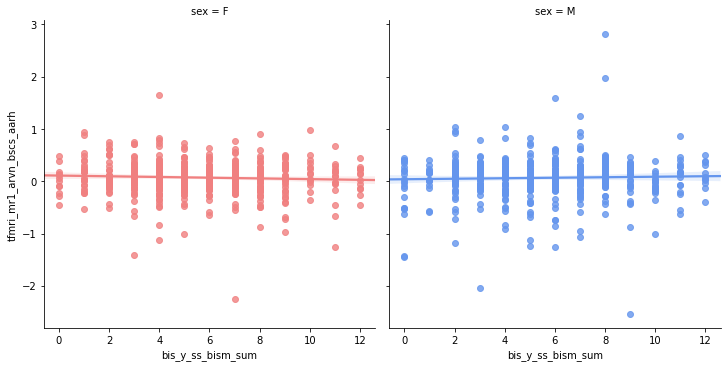

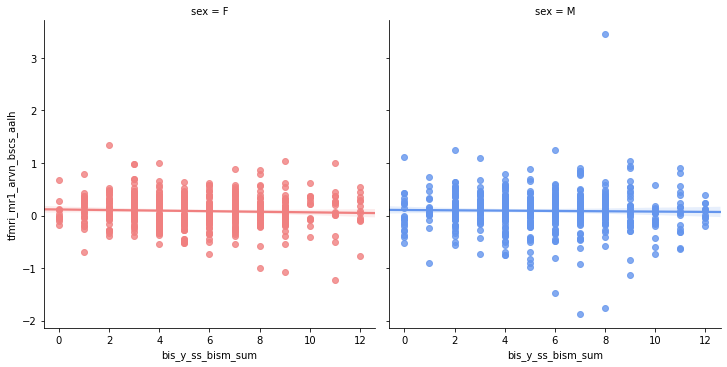

In [27]:
# Make a custom palette with gendered colors
# Note: this is equivalent to {"M": "#6495ED", "F": "#F08080"}
pal = dict(M="#6495ED", F="#F08080")

# Show the survival probability as a function of age and sex
g = sns.lmplot(x='bis_y_ss_bism_sum', y='tfmri_mr1_arvn_bscs_aarh', col="sex", hue="sex", data=subset_df,
               palette=pal, y_jitter=.02, logistic=False, truncate=False)
g = sns.lmplot(x='bis_y_ss_bism_sum', y='tfmri_mr1_arvn_bscs_aalh', col="sex", hue="sex", data=subset_df,
               palette=pal, y_jitter=.02, logistic=False, truncate=False)

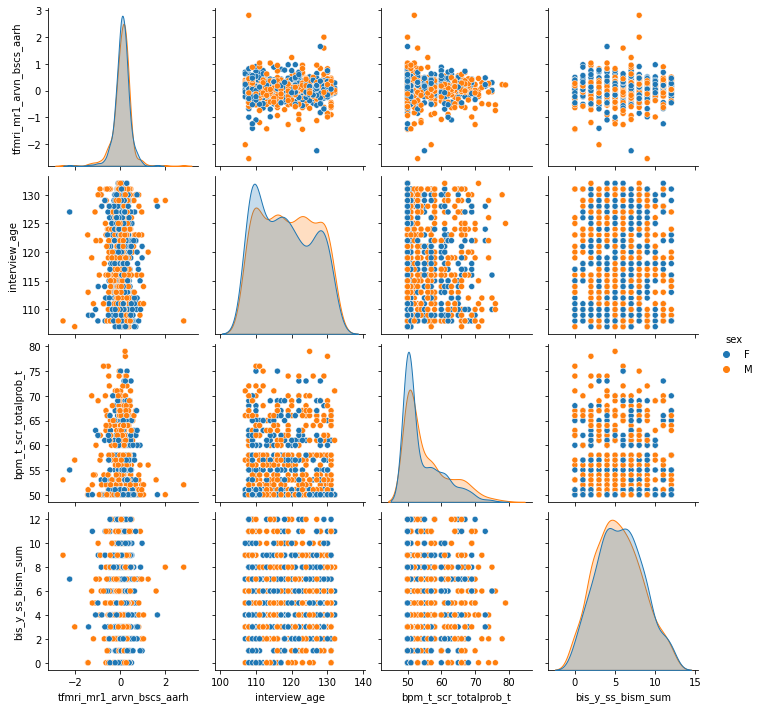

In [31]:
sns.pairplot(subset_df, hue="sex", vars=["tfmri_mr1_arvn_bscs_aarh", 'interview_age', 'bpm_t_scr_totalprob_t', "bis_y_ss_bism_sum"]);

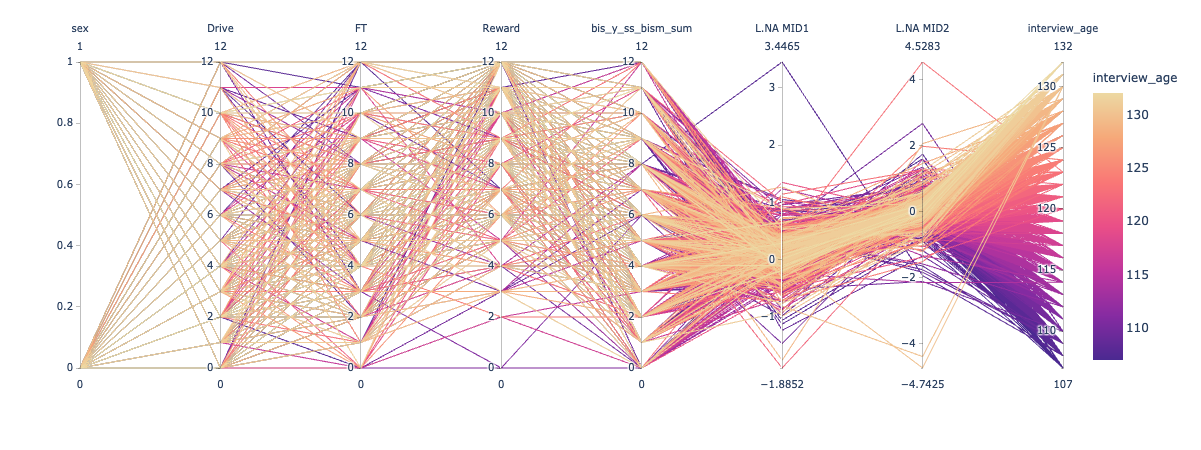

In [40]:
# Create an interactive parallel coordinate plot
subset_df_numerical = subset_df.copy()
subset_df_numerical.sex = subset_df.sex.astype("category").cat.codes
subset_df_numerical.site_id_l = subset_df.site_id_l.astype("category").cat.codes
fig = px.parallel_coordinates(subset_df_numerical, color="interview_age", 
                              dimensions=["sex", "bis_y_ss_basm_drive", "bis_y_ss_bas_fs", 'bis_y_ss_basm_rr', 'bis_y_ss_bism_sum', 
                                          "tfmri_mr1_arvn_bscs_aalh", "tfmri_mr2_arvn_bscs_aalh", "interview_age"], 
                              labels={"bis_y_ss_basm_drive": "Drive", "bis_y_ss_bas_fs": "FT", "bis_y_ss_basm_rr": "Reward",
                "tfmri_mr1_arvn_bscs_aalh": "L.NA MID1", "tfmri_mr2_arvn_bscs_aalh": "L.NA MID2", }, color_continuous_scale=px.colors.sequential.Agsunset,)
                              #color_continuous_midpoint=2)
fig.show()

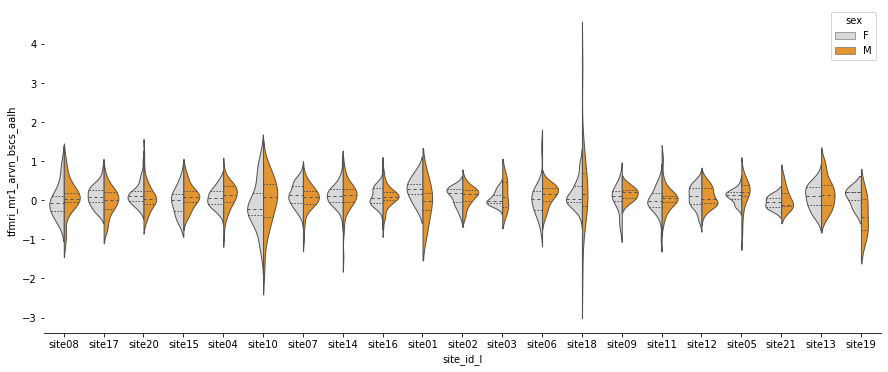

In [41]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=subset_df, x="site_id_l", y="tfmri_mr1_arvn_bscs_aalh", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"M": "#FF9914", "F": ".85"})
sns.despine(left=True)

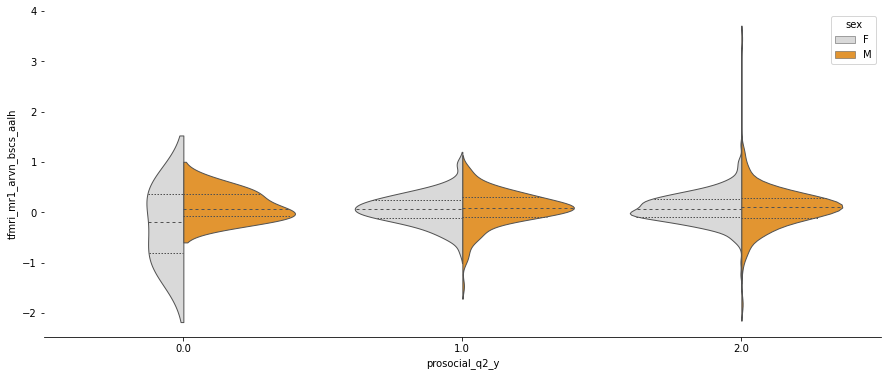

In [42]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=subset_df, x="prosocial_q2_y", y="tfmri_mr1_arvn_bscs_aalh", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"M": "#FF9914", "F": ".85"})
sns.despine(left=True)

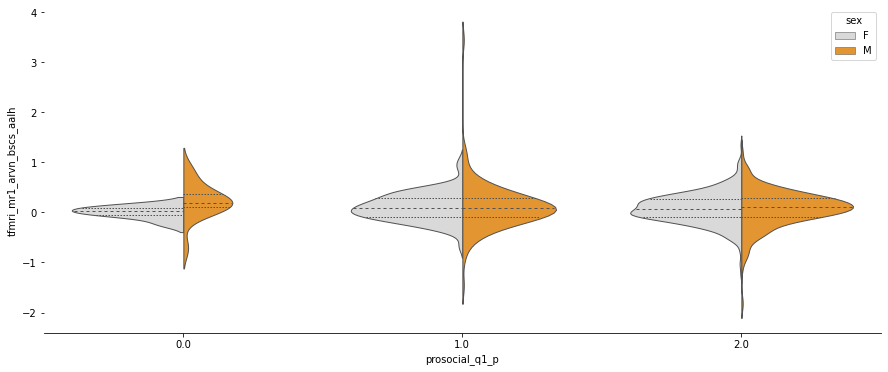

In [44]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=subset_df, x="prosocial_q1_p", y="tfmri_mr1_arvn_bscs_aalh", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"M": "#FF9914", "F": ".85"})
sns.despine(left=True)

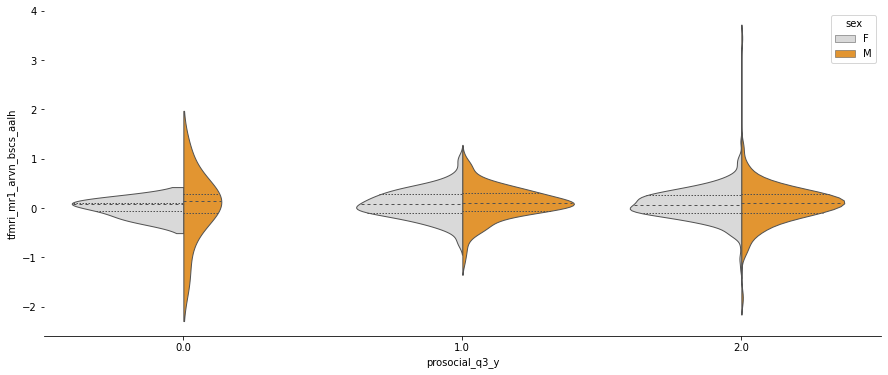

In [46]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=subset_df, x="prosocial_q3_y", y="tfmri_mr1_arvn_bscs_aalh", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"M": "#FF9914", "F": ".85"})
sns.despine(left=True)